<img src='otus.png'>

# LDA

**LDA** - Latent Dirichlet allocation. Не путать с Linear discriminant analysis (которую тоже часто сокращают как LDA).

Добавляем регуляризацию в виде априорного распределения на параметры $\theta_{d}$ и $\phi_{t}$.

* $p(t|d)$ - Categorical($\theta_{d}$)
* $p(w|t)$ ~ Categorical($\phi_{t}$)
* $\theta_{d}$ ~ Dirichlet($\alpha$)
* $\phi_{t}$ ~ Dirichlet($\beta$)


<img src='LogDirichletDensity-alpha_0.3_to_alpha_2.0.gif'>

<img src='latent-dirichlet-allocation-7-1024.jpg'>

$\alpha$ - большое значение - каждый документ представляет смесь большого числа тем, малое значение(<1) каждый документ включает в себя малое количество тем.

$\beta$ - большое значение - каждая тема представляет смесь большого числа слов, малое значение(<1) каждая тема включает в себя малое количество слов.

обучение:
 - семплирование Гиббса
 - вариационный байесовский вывод
 - метод Expectation-Propagation.

Примеры задач:

- ранжировать документы по степени релевантности заданной теме (тематический поиск);
- ранжировать документы по степени тематического сходства с заданным документом или его фрагментом;
- построить иерархический тематический каталог коллекции документов и выработать правила каталогизации новых документов;
- определить, как темы изменялись со временем (предполагается, что для каждого документа известно время его создания);
- определить тематику авторов (предполагается, что для каждого документа известен список авторов);
- определить тематику различных сущностей (entities), связанных с документами (например, журналов, конференций, организаций, стран);
- разбить документ на тематически однородные фрагменты.


[источник](http://www.machinelearning.ru/wiki/index.php?title=%D0%A2%D0%B5%D0%BC%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5)

библиотеки:
- pyLDAvis
- matplotlib
- numpy
- pandas
- gensim
- nltk


также можно установить:
```bash
pip install -r requirements.txt
```

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import re
import pickle
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import nltk
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
lemma = WordNetLemmatizer()

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nazhmeddinbabakhanov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nazhmeddinbabakhanov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Пример анализ тем в статьях NIPS

## https://www.kaggle.com/benhamner/nips-papers

In [4]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
stop_words = set(stop_words)

In [5]:
df = pd.read_csv('papers.csv')

In [6]:
print(df.shape)
df.head(10)

(7241, 7)


,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."
5,1002,1994,Using a neural net to instantiate a deformable...,NaN,1002-using-a-neural-net-to-instantiate-a-defor...,Abstract Missing,U sing a neural net to instantiate a\ndeformab...
6,1003,1994,Plasticity-Mediated Competitive Learning,NaN,1003-plasticity-mediated-competitive-learning.pdf,Abstract Missing,Plasticity-Mediated Competitive Learning\n\nTe...
7,1004,1994,ICEG Morphology Classification using an Analog...,NaN,1004-iceg-morphology-classification-using-an-a...,Abstract Missing,ICEG Morphology Classification using an\nAnalo...
8,1005,1994,Real-Time Control of a Tokamak Plasma Using Ne...,NaN,1005-real-time-control-of-a-tokamak-plasma-usi...,Abstract Missing,Real-Time Control of a Tokamak Plasma\nUsing N...
9,1006,1994,Pulsestream Synapses with Non-Volatile Analogu...,NaN,1006-pulsestream-synapses-with-non-volatile-an...,Abstract Missing,Real-Time Control of a Tokamak Plasma\nUsing N...


In [7]:
def clean(text):
    # Remove new line characters
    text = re.sub('\s+', ' ', text)
    # Remove distracting single quotes
    text = re.sub("\'", "", text)
    return text


def doc_to_words(doc, stop_words, lemma):
    stop_words = set(stop_words)
    # remove stop words and punctuation
    words = [w for w in gensim.utils.simple_preprocess(str(doc), deacc=True) if w not in stop_words]
    
    # make lemmatization
    words = [lemma.lemmatize(w) for w in words]
    
    return words

In [8]:
prepare = True

In [11]:
if prepare:
    # Convert to list
    data = df.paper_text.values.tolist()

    data = [clean(t) for t in data]
    data_words = [doc_to_words(t, stop_words, lemma) for t in data]
    
    with open('data.pkl', 'wb') as f:
        pickle.dump({'data': data, 'data_words': data_words}, f)
else:
    with open('data.pkl', 'rb') as f:
        d = pickle.load(f)
        data = d['data']
        data_words = d['data_words']

print(data_words[0][:40])

['self', 'organization', 'associative', 'database', 'application', 'hisashi', 'suzuki', 'suguru', 'arimoto', 'osaka', 'university', 'toyonaka', 'osaka', 'japan', 'abstract', 'efficient', 'method', 'self', 'organizing', 'associative', 'database', 'proposed', 'together', 'application', 'robot', 'eyesight', 'system', 'proposed', 'database', 'associate', 'input', 'output', 'first', 'half', 'part', 'discussion', 'algorithm', 'self', 'organization', 'proposed']


In [12]:
if prepare:
    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    bigram_mod.save('bigram_mod.pkl')
    
    data_words_bigrams = [bigram_mod[w] for w in data_words]
    with open('bigrams.pkl', 'wb') as f:
        pickle.dump(data_words_bigrams, f)

else:
    bigram_mod = gensim.models.Phrases.load('bigram_mod.pkl')
    
    with open('bigrams.pkl', 'rb') as f:
        data_words_bigrams = pickle.load(f)

In [13]:
data_words_bigrams[0][:10]

['self_organization',
 'associative',
 'database',
 'application',
 'hisashi',
 'suzuki',
 'suguru',
 'arimoto',
 'osaka',
 'university']

In [14]:
if prepare:
    id2word = corpora.Dictionary(data_words_bigrams)
    id2word.save('id2word.pkl')
else:
    id2word = corpora.Dictionary.load('id2word.pkl')

In [15]:
corpus = [id2word.doc2bow(text) for text in data_words_bigrams]

In [16]:
corpus[0][:10]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 2),
 (4, 1),
 (5, 6),
 (6, 1),
 (7, 1),
 (8, 3),
 (9, 1)]

In [17]:
id2word[8]

'actual'

In [18]:
data[0]

'767 SELF-ORGANIZATION OF ASSOCIATIVE DATABASE AND ITS APPLICATIONS Hisashi Suzuki and Suguru Arimoto Osaka University, Toyonaka, Osaka 560, Japan ABSTRACT An efficient method of self-organizing associative databases is proposed together with applications to robot eyesight systems. The proposed databases can associate any input with some output. In the first half part of discussion, an algorithm of self-organization is proposed. From an aspect of hardware, it produces a new style of neural network. In the latter half part, an applicability to handwritten letter recognition and that to an autonomous mobile robot system are demonstrated. INTRODUCTION Let a mapping f : X -+ Y be given. Here, X is a finite or infinite set, and Y is another finite or infinite set. A learning machine observes any set of pairs (x, y) sampled randomly from X x Y. (X x Y means the Cartesian product of X and Y.) And, it computes some estimate j : X -+ Y of f to make small, the estimation error in some measure. U

In [19]:
data[0].count('accordingly')

6

In [20]:
if prepare:
    lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=20, 
        random_state=100,
        update_every=1,
        chunksize=100,
        passes=10,
        alpha='auto',
        per_word_topics=True)
    lda_model.save('lda_default.pkl')
else:
    lda_model = gensim.models.ldamodel.LdaModel.load('lda_default.pkl')

In [21]:
print(lda_model.print_topics())

[(0, '0.024*"signal" + 0.021*"system" + 0.018*"time" + 0.016*"control" + 0.014*"source" + 0.012*"trajectory" + 0.012*"target" + 0.009*"noise" + 0.009*"dynamic" + 0.008*"figure"'), (1, '0.012*"arxiv_preprint" + 0.006*"st" + 0.006*"kx" + 0.005*"long_beach" + 0.005*"eq" + 0.005*"respectively" + 0.005*"th" + 0.004*"al" + 0.004*"ii" + 0.004*"following"'), (2, '0.023*"point" + 0.012*"solution" + 0.011*"function" + 0.009*"one" + 0.009*"case" + 0.009*"equation" + 0.008*"value" + 0.008*"problem" + 0.008*"local" + 0.008*"constraint"'), (3, '0.069*"image" + 0.020*"object" + 0.014*"convolutional" + 0.011*"pixel" + 0.010*"model" + 0.009*"map" + 0.008*"visual" + 0.008*"recognition" + 0.008*"using" + 0.008*"frame"'), (4, '0.032*"algorithm" + 0.022*"problem" + 0.019*"optimization" + 0.017*"method" + 0.017*"function" + 0.013*"gradient" + 0.012*"loss" + 0.011*"convex" + 0.011*"learning" + 0.010*"objective"'), (5, '0.012*"set" + 0.010*"number" + 0.009*"algorithm" + 0.008*"query" + 0.008*"data" + 0.007*"p

In [22]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/nazhmeddinbabakhanov/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
8     -0.120690 -0.030491       1        1  9.901272
9     -0.143134 -0.139848       2        1  9.693247
18    -0.091300 -0.036838       3        1  9.282256
4     -0.151103 -0.130042       4        1  7.850214
5     -0.113533  0.010992       5        1  7.405786
17    -0.032095  0.072776       6        1  5.800650
6     -0.081601  0.058402       7        1  4.932879
2     -0.030023 -0.130904       8        1  4.771266
14    -0.064703  0.001148       9        1  4.701955
12    -0.087980 -0.101142      10        1  4.528496
16    -0.060539 -0.047934      11        1  4.353223
10     0.079584  0.137130      12        1  4.250975
3      0.018661  0.097130      13        1  3.928612
13    -0.019813  0.109363      14        1  3.803838
11     0.110095  0.111360      15        1  3.077879
7      0.080447  0.112493      16        1  2.677049
19     0.074395  0.033479      17        1  2.635068
1      0.351298 -0.342546      18        1  2.319376
0      0.164169  0.141722      19        1  2.284914
15     0.117867  0.073750      20        1  1.801044, topic_info=      Category           Freq            Term          Total  loglift  logprob
term                                                                          
451    Default  155710.000000           model  155710.000000  30.0000  30.0000
470    Default   78634.000000         network   78634.000000  29.0000  29.0000
346    Default   45251.000000           image   45251.000000  28.0000  28.0000
1038   Default   51044.000000          matrix   51044.000000  27.0000  27.0000
275    Default   40978.000000         feature   40978.000000  26.0000  26.0000
16     Default  118185.000000       algorithm  118185.000000  25.0000  25.0000
400    Default  106527.000000        learning  106527.000000  24.0000  24.0000
747    Default   46448.000000        training   46448.000000  23.0000  23.0000
737    Default   64073.000000            time   64073.000000  22.0000  22.0000
3203   Default   25340.000000           graph   25340.000000  21.0000  21.0000
1065   Default   22107.000000          neuron   22107.000000  20.0000  20.0000
204    Default   59960.000000    distribution   59960.000000  19.0000  19.0000
2025   Default   37705.000000           bound   37705.000000  18.0000  18.0000
163    Default   91194.000000            data   91194.000000  17.0000  17.0000
476    Default   24332.000000            node   24332.000000  16.0000  16.0000
471    Default   51518.000000          neural   51518.000000  15.0000  15.0000
1174   Default   45985.000000           state   45985.000000  14.0000  14.0000
723    Default   32570.000000            task   32570.000000  13.0000  13.0000
528    Default   44397.000000           point   44397.000000  12.0000  12.0000
2455   Default   46700.000000             log   46700.000000  11.0000  11.0000
301    Default   94123.000000        function   94123.000000  10.0000  10.0000
1013   Default   22732.000000           layer   22732.000000   9.0000   9.0000
365    Default   42050.000000           input   42050.000000   8.0000   8.0000
5934   Default   19280.000000          policy   19280.000000   7.0000   7.0000
4739   Default   25168.000000          kernel   25168.000000   6.0000   6.0000
1846   Default   27308.000000    optimization   27308.000000   5.0000   5.0000
2038   Default   20053.000000  classification   20053.000000   4.0000   4.0000
7562   Default   26733.000000         theorem   26733.000000   3.0000   3.0000
106    Default   27085.000000           class   27085.000000   2.0000   2.0000
721    Default   44755.000000          system   44755.000000   1.0000   1.0000
...        ...            ...             ...            ...      ...      ...
509    Topic20    3615.499512        parallel    5481.277832   3.6007  -4.4049
1177   Topic20     980.827209         storage    1272.887817   3.7562  -5.7095
2863   Topic20     799.410

In [23]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.1511620788597

Coherence Score:  0.4549351316322289


In [24]:
lda_model.get_document_topics(corpus[22])

[(2, 0.045032065),
 (4, 0.14352714),
 (5, 0.05436631),
 (6, 0.010054997),
 (7, 0.016013429),
 (8, 0.11550377),
 (9, 0.049558338),
 (14, 0.46212906),
 (17, 0.0706791)]

In [25]:
data[22]

'Generalization in Reinforcement Learning: Safely Approximating the Value Function Justin A. Boyan and Andrew W. Moore Computer Science Department Carnegie Mellon University Pittsburgh, PA 15213 jab@cs.cmu.edu, awm@cs.cmu .edu Abstract A straightforward approach to the curse of dimensionality in reinforcement learning and dynamic programming is to replace the lookup table with a generalizing function approximator such as a neural net. Although this has been successful in the domain of backgammon, there is no guarantee of convergence. In this paper, we show that the combination of dynamic programming and function approximation is not robust, and in even very benign cases, may produce an entirely wrong policy. We then introduce Grow-Support, a new algorithm which is safe from divergence yet can still reap the benefits of successful generalization . 1 INTRODUCTION Reinforcement learning-the problem of getting an agent to learn to act from sparse, delayed rewards-has been advanced by techn

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics, 
            random_state=100,
            update_every=1,
            chunksize=100,
            passes=10,
            alpha='auto',
            per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words_bigrams, start=2, limit=40, step=6)

In [ ]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
if prepare:
    lda_model_opt = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=8, 
        random_state=100,
        update_every=1,
        chunksize=100,
        passes=10,
        alpha='auto',
        per_word_topics=True)
    lda_model_opt.save('lda_opt.pkl')
else:
    lda_model_opt = gensim.models.ldamodel.LdaModel.load('lda_opt.pkl')

In [ ]:
pprint(lda_model_opt.print_topics())

In [ ]:
doc_rl1 = '''Deep reinforcement learning on Atari games maps pixel directly to actions; internally,
the deep neural network bears the responsibility of both extracting useful
information and making decisions based on it. Aiming at devoting entire deep
networks to decision making alone, we propose a new method for learning policies
and compact state representations separately but simultaneously for policy
approximation in reinforcement learning. State representations are generated by a
novel algorithm based on Vector Quantization and Sparse Coding, trained online
along with the network, and capable of growing its dictionary size over time. We
also introduce new techniques allowing both the neural network and the evolution
strategy to cope with varying dimensions. This enables networks of only 6 to 18
neurons to learn to play a selection of Atari games with performance comparable—
and occasionally superior—to state-of-the-art techniques using evolution strategies
on deep networks two orders of magnitude larger.'''


doc_rl2 = '''Deep reinforcement learning methods traditionally struggle with tasks where environment
rewards are particularly sparse. One successful method of guiding
exploration in these domains is to imitate trajectories provided by a human demonstrator.
However, these demonstrations are typically collected under artificial
conditions, i.e. with access to the agent’s exact environment setup and the demonstrator’s
action and reward trajectories. Here we propose a two-stage method that
overcomes these limitations by relying on noisy, unaligned footage without access
to such data. First, we learn to map unaligned videos from multiple sources to a
common representation using self-supervised objectives constructed over both time
and modality (i.e. vision and sound). Second, we embed a single YouTube video
in this representation to construct a reward function that encourages an agent to
imitate human gameplay. This method of one-shot imitation allows our agent to
convincingly exceed human-level performance on the infamously hard exploration
games MONTEZUMA’S REVENGE, PITFALL! and PRIVATE EYE for the first time†
,
even if the agent is not presented with any environment rewards.
'''

doc_cv = '''Convolutional Neural Networks (CNNs) have become the method of choice 
for learning problems involving 2D planar images. However, a number of problems of recent 
interest have created a demand for models that can analyze spherical images. 
Examples include omnidirectional vision for drones, robots, and autonomous cars, 
molecular regression problems, and global weather and climate modelling. 
A naive application of convolutional networks to a planar projection of the spherical signal
is destined to fail, because the space-varying distortions introduced by such a projection will
make translational weight sharing ineffective.
In this paper we introduce the building blocks for constructing spherical CNNs. 
We propose a definition for the spherical cross-correlation that is both expressive and rotation-equivariant.
The spherical correlation satisfies a generalized Fourier theorem, which allows us to compute 
it efficiently using a generalized (non-commutative) Fast Fourier Transform (FFT) algorithm.
We demonstrate the computational efficiency, numerical accuracy, and effectiveness of spherical 
CNNs applied to 3D model recognition and atomization energy regression.
'''

In [ ]:
def doc2bowl_bigram(doc):
    doc = clean(doc)
    words = doc_to_words(doc, stop_words, lemma)
    bigrams = bigram_mod[words]
    bow = id2word.doc2bow(bigrams)
    return bow, bigrams

In [ ]:
bow_rl1, bigrams_rl1 = doc2bowl_bigram(doc_rl1)
bow_rl2, bigrams_rl2 = doc2bowl_bigram(doc_rl2)
bow_cv, bigrams_cv = doc2bowl_bigram(doc_cv)

In [ ]:
bigrams_rl1

In [ ]:
lda_model_opt.get_document_topics(bow_rl1)

In [ ]:
lda_model_opt.get_document_topics(bow_rl2)

In [ ]:
lda_model_opt.get_document_topics(bow_cv)

In [ ]:
def bow2feat(bow):
    return np.asarray([x for _, x in lda_model.get_document_topics(bow, minimum_probability=0)])


def doc2feat(doc):
    bow, _ = doc2bowl_bigram(doc)
    return bow2feat(bow)

In [ ]:
feat_rl1 = doc2feat(doc_rl1)
feat_rl2 = doc2feat(doc_rl2)
feat_cv = doc2feat(doc_cv)

In [ ]:
print(feat_rl1.shape)
feat_rl1

In [ ]:
from scipy.spatial import distance
from itertools import combinations

In [ ]:
names = ['rl1', 'rl2', 'cv']
feats = [feat_rl1, feat_rl2, feat_cv]
names_feat = zip(names, feats)

for (n1, f1), (n2, f2) in combinations(names_feat, 2):
    print('doc1: {}, doc2: {}, similarity {:.2f}'.format(n1, n2, distance.euclidean(f1, f2)))

# Russian example

https://github.com/maxoodf/russian_news_corpus

```bash
git clone https://github.com/maxoodf/russian_news_corpus.git
cd ./russian_news_corpus
cat ./russian_news.txt.bz2_a* | bzip2 -d > ./russian_news.txt
cat russian_news.txt | awk 'BEGIN {srand()} !/^$/ { if (rand() <= .005) print $0}' > russian_news_10k.txt
```

In [199]:
stop_words = set(stopwords.words('russian'))

In [208]:
from pathlib import Path

In [241]:
data_ru = Path('/media/storage/data_nlp/russian_news_corpus/russian_news_10k.txt').read_text(encoding='utf-8').split('\n')

In [242]:
def doc_to_words_ru(doc, stop_words):
    stop_words = set(stop_words)
    # remove stop words and punctuation
    words = [w for w in gensim.utils.simple_preprocess(str(doc), deacc=True, max_len=100) if w not in stop_words]
    
    return words

In [ ]:
prepare = False

In [243]:
data_ru = [clean(t) for t in data_ru]
data_words_ru = [doc_to_words_ru(t, stop_words) for t in data_ru]

In [244]:
data_words_ru[0][:10]

['сми',
 'называть',
 'украина',
 'коррумпированныи',
 'болото',
 'мир',
 'политика',
 'аргумент',
 'факт',
 'москва']

In [245]:
# Build the bigram and trigram models
bigram_ru = gensim.models.Phrases(data_words_ru, min_count=5, threshold=100) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod_ru = gensim.models.phrases.Phraser(bigram_ru)
    
data_words_bigrams_ru = [bigram_mod_ru[w] for w in data_words_ru]

In [246]:
data_words_bigrams_ru[1][:10]

['цивилизованныи',
 'подход',
 'наркоз',
 'город',
 'новость',
 'санкт_петербург',
 'фонтанка_ру',
 'приморскии',
 'раион',
 'петербург']

In [247]:
id2word_ru = corpora.Dictionary(data_words_bigrams_ru)
corpus_ru = [id2word_ru.doc2bow(text) for text in data_words_bigrams_ru]

In [248]:
lda_model_ru = gensim.models.ldamodel.LdaModel(
    corpus=corpus_ru,
    id2word=id2word_ru,
    num_topics=20, 
    random_state=100,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True)

In [249]:
pprint(lda_model_ru.print_topics())

[(0,
  '0.021*"человек" + 0.020*"москва" + 0.019*"сообщать" + 0.011*"место" + '
  '0.011*"происходить" + 0.009*"улица" + 0.009*"здание" + 0.008*"находиться" + '
  '0.008*"мужчина" + 0.008*"погибать"'),
 (1,
  '0.027*"сбербанк" + 0.015*"минфин" + 0.015*"снижаться" + 0.011*"магазин" + '
  '0.010*"продукт" + 0.010*"ставка" + 0.009*"мост" + 0.008*"валюта" + '
  '0.008*"реитинг" + 0.008*"выпуск"'),
 (2,
  '0.034*"крым" + 0.025*"интернет" + 0.023*"депутат" + 0.019*"закон" + '
  '0.016*"госдума" + 0.012*"законопроект" + 0.008*"депутат_госдума" + '
  '0.007*"лнр" + 0.007*"нилов" + 0.007*"сеть"'),
 (3,
  '0.015*"сирия" + 0.014*"военныи" + 0.014*"оон" + 0.011*"город" + '
  '0.010*"посол" + 0.010*"сша" + 0.009*"сила" + 0.009*"нато" + '
  '0.008*"россиискии" + 0.008*"россия"'),
 (4,
  '0.022*"суд" + 0.020*"дело" + 0.019*"год" + 0.009*"сотрудник" + '
  '0.009*"задерживать" + 0.009*"сообщать" + 0.008*"которыи" + 0.008*"бывшии" + '
  '0.006*"убииство" + 0.006*"экс"'),
 (5,
  '0.008*"роман" + 0.008*"и

In [250]:
with open('lda_ru', 'wb') as f:
    pickle.dump({
        "data_ru": data_ru,
        "data_words_ru": data_words_ru,
        "bigram_mod_ru": bigram_mod_ru,
        "data_words_bigrams_ru": data_words_bigrams_ru,
        "id2word_ru": id2word_ru,
        "corpus_ru": corpus_ru,
        "lda_model_ru": lda_model_ru,
    }, f)

In [295]:
model_list_ru, coherence_values_ru = compute_coherence_values(
    dictionary=id2word_ru, corpus=corpus_ru, texts=data_words_bigrams_ru, start=2, limit=40, step=6)

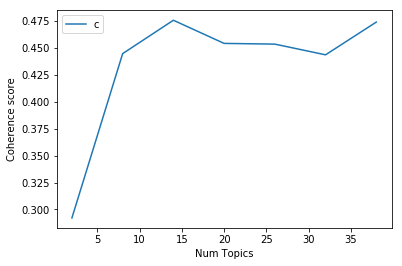

In [297]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values_ru)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [301]:
lda_model_opt_ru = model_list_ru[2]
lda_model_opt_ru.save('lda_model_opt_ru.pkl')

In [300]:
lda_model_opt_ru.print_topics()

[(0,
  '0.023*"человек" + 0.015*"москва" + 0.013*"сообщать" + 0.010*"место" + 0.010*"город" + 0.010*"происходить" + 0.008*"дом" + 0.008*"улица" + 0.007*"здание" + 0.007*"данные"'),
 (1,
  '0.039*"год" + 0.025*"банк" + 0.014*"рубль" + 0.012*"составлять" + 0.012*"компания" + 0.011*"рынок" + 0.009*"рост" + 0.009*"млн" + 0.009*"цена" + 0.008*"млрд"'),
 (2,
  '0.015*"крым" + 0.009*"новыи" + 0.009*"ребенок" + 0.007*"завод" + 0.007*"интернет" + 0.007*"работа" + 0.007*"специалист" + 0.007*"ученыи" + 0.006*"школа" + 0.006*"год"'),
 (3,
  '0.025*"суд" + 0.023*"дело" + 0.012*"год" + 0.012*"задерживать" + 0.009*"сотрудник" + 0.008*"убииство" + 0.008*"которыи" + 0.007*"полиция" + 0.007*"бывшии" + 0.006*"мвд"'),
 (4,
  '0.022*"год" + 0.019*"сообщать" + 0.015*"москва" + 0.015*"россия" + 0.013*"риа_новость" + 0.012*"россиискии" + 0.011*"март" + 0.009*"новость" + 0.008*"тасс" + 0.006*"проходить"'),
 (5,
  '0.012*"аукцион" + 0.012*"грузия" + 0.010*"чечня" + 0.009*"дипломат" + 0.007*"месторождение" + 0.0

# References

LDA material:
- http://www.cs.columbia.edu/~blei/talks/Blei_Topic_Modeling_Workshop_2013.pdf
- http://www.cs.columbia.edu/~blei/papers/Blei2012.pdf
- http://www.machinelearning.ru/wiki/images/8/82/BMMO11_14.pdf
- http://www.machinelearning.ru/wiki/images/f/f7/DirichletProcessNotes.pdf 

coherence article:
- http://www.aclweb.org/anthology/N10-1012